# 価格は適正

今日、商品の価格を推定するためのより複雑なソリューションを構築しています。

1. Day2.0ノートブック：RAG-DB作成
2. Day2.1ノートブック：2Dで視覚化
3. Day2.2ノートブック：3Dで視覚化
4. Day2.3ノートブック：GPT-4o miniでRAGパイプラインを構築してテスト
5. Day2.4ノートブック：(a) ランダムフォレストプライザー (b)アンサンブルプライザーを作成

うーん！それは一日で乗り越えるのにたくさんのことです！

## ご注意ください：

私たちはすでに、独自のファインチューニングされたLLMを使用して非常に強力な製品推定器を持っています。  

ほとんどの人はそれに非常に満足するでしょう！これらの追加の手順を追加する主な理由は、RAGとエージェント・ワークフローで専門知識を深めることです。

## 今日は早く行きますよ！帽子をしっかり押さえて。

In [1]:
# import

# 基本的な
import os
import re
import math
import json
import random
import pickle

# HF
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset

# RAG
import chromadb
from sentence_transformers import SentenceTransformer

# LLM
from openai import OpenAI

# 可視化
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# .envファイルから環境変数をロード

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Hugging Faceにログイン

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [4]:
# testing.py からの import
# items.py からの import - ありがとう、Trung N.！

from testing import Tester
from items import Item

In [5]:
openai = OpenAI()

In [6]:
# test.pklファイルをロード ... 取得手順は、`day2.0_ja.ipynb` を参照の事。

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
# RAGで取得した製品情報チャンクからコンテキストを生成
def make_context(similars, prices):
    # 背景を説明すると、見積もる必要のある項目に類似している可能性のある他の項目をいくつか示します。
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    
    for similar, price in zip(similars, prices):
        # message += of"潜在的に関連のある製品:\in{similar}\価格は ${price:.2f}\n\n"
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
        
    return message

In [8]:
# 製品情報とチャンクからプロンプトを生成
def messages_for(item, similars, prices):
    
    # 商品の価格を見積もる。価格のみを返信し、説明は不要。
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    
    # RAGで取得した製品情報チャンクからコンテキストを生成
    user_prompt = make_context(similars, prices) # 前述の関数を呼び出す
    
    # さて、あなたへの質問です
    user_prompt += "And now the question for you:\n\n"
    
    # test_prompt から user_prompt（フロンティアモデルで不要な情報と価格情報を消す）
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")

    # プロンプト
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [9]:
# VDBのコレクション
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [10]:
# プロンプトから「商品の説明文」だけを抽出
# ・冒頭の定型文を削除
# ・末端の価格行を削除
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [11]:
# All-Minilmは、文と段落を384次元密度のベクトル空間にマッピングするHugging Faceの非常に便利なモデルであり、セマンティック検索などのタスクに最適です。
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [12]:
# テキストをベクトル化
def vector(item):
    return model.encode([description(item)])

In [13]:
# 製品情報チャンク（ベクトルと類似の元文書と価格）を取得
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [14]:
# Itemのプロンプト
print(test[1].prompt)

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [15]:
# Itemのプロンプトから製品情報チャンクを取得
documents, prices = find_similars(test[1])

In [16]:
# 製品情報チャンクからコンテキストを生成
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
Price is $223.78

Potentially related product:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power Source Electric, Style Modern, Dimensi

In [17]:
# プロンプトをコンテキスト、製品情報チャンクから生成
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nMotorcraft Fan Clutch Assembly - YB3130\nMotorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches\nPrice is $223.78\n\nPotentially related product:\nMotorcraft- YB3126 Fan Clutch\nFan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB31

In [18]:
# 文字列から価格を抽出する関数

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [19]:
# 価格抽出関数をテストする
get_price("The price for this is $99.99")

99.99

In [20]:
# itemのプロンプトからgpt-4o-mini＋RAGで推定した値を返す

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [21]:
# 推論の単体テスト
gpt_4o_mini_rag(test[1])

198.45

In [22]:
test[1].price

225.11

1: Guess: $312.41 Truth: $374.41 Error: $62.00 SLE: 0.03 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $198.45 Truth: $225.11 Error: $26.66 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $44.99 Truth: $61.68 Error: $16.69 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $449.99 Truth: $599.99 Error: $150.00 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $599.99 Truth: $635.86 Error: $35.87 SLE: 0.00 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $56.99 Truth: $65.99 Error: $9.00 SLE: 0.02 Ite

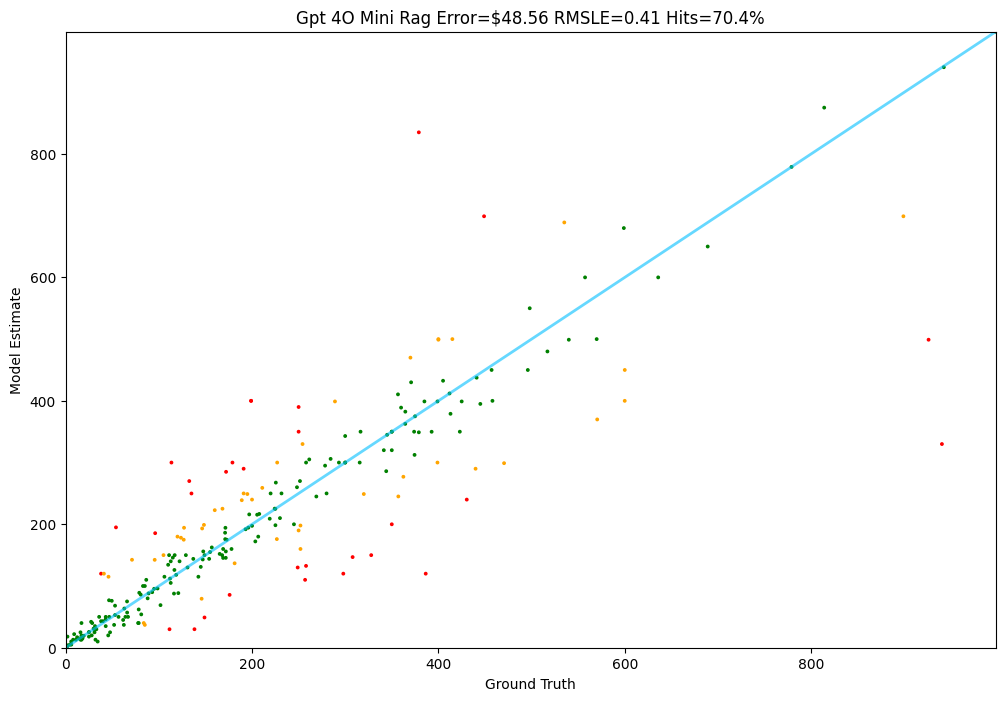

In [23]:
# TestRunnerを実行
Tester.test(gpt_4o_mini_rag, test)

## オプションの追加：OpenAIの代わりにDeepSeek API呼び出しを試す

DeepSeek APIキーがある場合は、ここでは代替実装として使用します。それ以外の場合は、次のセクションにスキップします。

In [ ]:
# OpenAI Client Python Library を使用してDeepSeekに接続

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [ ]:
# DeepSeekは非常に過剰にサブスクライブされ、時には失敗するため、ここにいくつかの再試行ロジックを追加しました。

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek-chat", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [ ]:
# 推論の単体テスト
deepseek_api_rag(test[1])

In [ ]:
test[1].price

In [ ]:
# TestRunnerを実行
Tester.test(deepseek_api_rag, test)

## そして今、これを「エージェント」クラスでラップします。

In [24]:
# 何が起こっているのかを見ることができるように、ログ出力
import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [25]:
# 今作った、Frontier LLM＋RAGのエージェント

# `./agents/frontier_agent.py`
from agents.frontier_agent import FrontierAgent

In [26]:
# 初期化
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [27]:
# itemのプロンプトからFrontier LLM＋RAGで推定した値を返す
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $154.59


154.59

In [28]:
# `day1_ja.ipynb`で、開発済みの、ファインチューニングされたLLMのエージェント

# `./agents/specialist_agent.py`
from agents.specialist_agent import SpecialistAgent

In [29]:
# 初期化
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
INFO:root:[Specialist Agent] Specialist Agent is ready


In [30]:
# itemのプロンプトからファインチューニングされたLLMで推定した値を返す
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Specialist Agent] Specialist Agent is calling remote fine-tuned model
INFO:root:[Specialist Agent] Specialist Agent completed - predicting $189.00


189.0